# Task 3 : Prompt Engineering for Large Language Models (LLMs) [4 marks]

## Questions

1. Demonstrate how to use Zero-Shot Learning and Few-Shot Learning to classify human activities based on the featurized accelerometer data. Qualitatively demonstrate the performance of Few-Shot Learning with Zero-Shot Learning. Which method performs better? Why? **[1 marks]**
2. Quantitatively compare the accuracy of Few-Shot Learning with Decision Trees (You may use a subset of the test set if you encounter rate-limiting issues). Which method performs better? Why? **[1 marks]**
3. What are the limitations of Zero-Shot Learning and Few-Shot Learning in the context of classifying human activities based on featurized accelerometer data? **[1 marks]**
4. What does the model classify when given input from an entirely new activity that it hasn't seen before? **[0.5 mark]**
5. Test the model with random data (ensuring the data has the same dimensions and range as the previous input) and report the results. **[0.5 mark]**

In this notebook, we evaluate the performance of the large language models on the task of classifying human activities based on featurized accelerometer data. We will use the accelerometer data to classify human activities using Zero-Shot Learning and Few-Shot Learning. We will also compare the performance of Few-Shot Learning with Decision Trees. We do this on the UCI HAR dataset features.

## Imports

In [26]:
import pandas as pd 
from langchain_groq.chat_models import ChatGroq
from dotenv import load_dotenv
import os
from typing import Union
import sys
sys.path.append(os.path.abspath('..'))
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from GenerateDataset import generate_dataset
from MakeHARdataset import X_train, X_test, y_train, y_test
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Utility Functions and classes

In [2]:
activity_classes = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

def get_sample_data(path, files_per_activity=-1):
    sample_data = []
    for activity_class in activity_classes:
        subpath = os.path.join(os.path.abspath('..'), path, activity_class)
        files = os.listdir(subpath)
        num_files = len(files) if files_per_activity == -1 else files_per_activity
        for file in range(num_files):
            sample_data.append(os.path.join(subpath, files[file]))
    return sample_data

def load_csv_files(directory, label, add_timestamp=True, add_total_acc=True, trim_data=True):
    df_list = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            df['subject'] = filename.replace('.csv', '')
            if add_timestamp:
                df['timestamp'] = (df.index + 1) / 50
            if add_total_acc:
                df['total_acc'] = df['accx'] ** 2 + df['accy'] ** 2 + df['accz'] ** 2
            if trim_data:
                df_list.append(df.iloc[100:600, :])
            else:
                df_list.append(df)
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df['y'] = label
    return combined_df

def prepare_dataset(path):
    train_path = os.path.join(path, "Train")
    test_path = os.path.join(path, "Test")
    
    train_dfs = pd.concat([load_csv_files(os.path.join(train_path, activity_class), label) for label, activity_class in enumerate(activity_classes)])
    test_dfs = pd.concat([load_csv_files(os.path.join(test_path, activity_class), label) for label, activity_class in enumerate(activity_classes)])
    
    return train_dfs, test_dfs

def get_tsfel_features(tsfel_features_path):   
    data = pd.DataFrame()
    for label, activity_class in enumerate(activity_classes):
        folder_path = os.path.join(tsfel_features_path, activity_class)
        dfs = load_csv_files(folder_path, label, False, False, False)
        data = pd.concat([data, dfs], axis=0, ignore_index=True)
    return data

In [3]:
class Example:
    def __init__(self, data: Union[pd.DataFrame, None], classification: Union[str, None], modify=False, precision=None):
        self.data = self.modify_data(data, precision) if modify else data
        self.classification = classification
        self.text = self.format_data_to_string(self.data)

    @staticmethod
    def modify_data(data: Union[pd.DataFrame, None], precision=None):
        data = data.round(precision if precision is not None else 0) if data is not None else data
        return data
    
    @staticmethod
    def format_data_to_string(data: Union[pd.DataFrame, None]) -> str:
        if data is not None:
            array = data.to_numpy()
            array_str = np.array2string(array, separator=',', threshold=np.inf, max_line_width=np.inf)
            formatted_str = re.sub(r'[\[\]]', '', array_str).replace(' ', '')
            return formatted_str
        return ''

In [4]:
titles = [activity.title().replace('_', ' ') for activity in activity_classes]

In [5]:
load_dotenv()
groq_models = {"llama-3.1-8b-instant": "llama-3.1-8b-instant", "llama-3.1-70b-versatile": "llama-3.1-70b-versatile", "llama3-70b": "llama3-70b-8192", "mixtral": "mixtral-8x7b-32768", "gemma-7b": "gemma-7b-it","llama3.1-70b":"llama-3.1-70b-versatile","llama3-8b":"llama3-8b-8192","llama3.1-8b":"llama-3.1-8b-instant","gemma-9b":"gemma2-9b-it"}

In [6]:
def clean_data(folder: str = 'Train'):
    dataset_features = generate_dataset(filepath=r"C:\Users\Nishchay\Desktop\College\ES 335 Machine Learning\Assignments\es335-24-fall-assignment-1\Datasets\UCI HAR Dataset", folder=folder).columns
    features = ['tBodyAcc_mean()_X', 'tBodyAcc_mean()_Y', 'tBodyAcc_mean()_Z', 'tGravityAcc_mean()_X', 'tGravityAcc_mean()_Y', 'tGravityAcc_mean()_Z', 'tBodyGyro_mean()_X', 'tBodyGyro_mean()_Y', 'tBodyGyro_mean()_Z', 'y']

    X = X_train if folder != 'Test' else X_test
    y = y_train if folder != 'Test' else y_test

    dataframes = [pd.DataFrame(dataframe, columns=dataset_features[:-1]).assign(y=label) for dataframe, label in zip(X, y)]
    labels = []
    np.random.seed = 101
    np.random.shuffle(dataframes)

    for i in range(len(dataframes)):
        labels.append(titles[int(dataframes[i].iloc[0, -1])])
        dataframes[i] = dataframes[i][features[:-1]]
        dataframes[i] = dataframes[i].iloc[10:20, :]

    return dataframes, labels

train_dataframes, train_labels = clean_data('Train')
test_dataframes, test_labels = clean_data('Test')

train_examples = [Example(dataframe, label, True, 3) for dataframe, label in zip(train_dataframes, train_labels)]
test_examples = [Example(dataframe, label, True, 3) for dataframe, label in zip(test_dataframes, test_labels)]

Loading feature data from c:\Users\Nishchay\Desktop\College\ES 335 Machine Learning\Assignments\es335-24-fall-assignment-1\Datasets\UCI HAR Dataset\train...
Loading feature data from c:\Users\Nishchay\Desktop\College\ES 335 Machine Learning\Assignments\es335-24-fall-assignment-1\Datasets\UCI HAR Dataset\test...


# 1. Zero-Shot Learning and Few-Shot Learning

Demonstrate how to use Zero-Shot Learning and Few-Shot Learning to classify human activities based on the featurized accelerometer data. Qualitatively demonstrate the performance of Few-Shot Learning with Zero-Shot Learning. Which method performs better? Why?

We ran several experiments for both the zero shot learning and few shot learning. We use the llama-3.1-70b-versatile model. For zero-shot learning, we get 20.37% accuracy, while for few-shot learning maximum accuracy we get is 64.81%. Few-shot learning performs better than zero-shot learning because it has seen some examples of the classes. Zero-shot learning has never seen any examples of the classes. This is because the large language models have a context window, where it can infer the class of the model based on the data which it has seen before. Hence we get that the few shot model performs better than the zero-shot model.

Note: For few-shot, we are providing all the training examples in the prompt and testing the data on the testing examples from the UCI HAR dataset.

## Zero Shot

In [7]:
num_api_keys = 12
model_name = "llama-3.1-70b-versatile"

In [17]:
cur_api_key = 1

query_str = """You are given some values of the following features of a human, in order:
1. tBodyAcc-mean()-X: Mean of the body acceleration signal in the X-axis (horizontal movement).
2. tBodyAcc-mean()-Y: Mean of the body acceleration signal in the Y-axis (vertical movement).
3. tBodyAcc-mean()-Z: Mean of the body acceleration signal in the Z-axis (lateral movement).
4. tGravityAcc-mean()-X: Mean of the gravity acceleration signal in the X-axis.
5. tGravityAcc-mean()-Y: Mean of the gravity acceleration signal in the Y-axis.
6. tGravityAcc-mean()-Z: Mean of the gravity acceleration signal in the Z-axis.
7. tBodyGyro_mean()_X: Mean of the body gyro signal in the X-axis.
8. tBodyGyro_mean()_Y: Mean of the body gyro signal in the Y-axis.
9. tBodyGyro_mean()_Z: Mean of the body gyro signal in the Z-axis.

Now classify the below activities into one of these activities: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs. Make sure you limit your response for each activity to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess:

"""

test_template = """
=======================================================
Activity {activity_number}:

{activity}

"""

for cur_example, example in enumerate(test_examples):
    query_str += test_template.format(activity_number=cur_example + 1, activity=example.text)

response = None
while not response:
    try:
        llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
        response = llm.invoke(query_str).content.strip()
    except:
        cur_api_key = (cur_api_key % num_api_keys) + 1

In [18]:
classifications = response.split('\n')[2:]
classifications = [classification[classification.index('.')+2:] for classification in classifications]

correct = sum(1 if classification == test_labels[i] else 0 for i, classification in enumerate(classifications))
total = 54
accuracy = correct / total

accuracy *= 100
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 20.37%


In [ ]:
query_str = """You are given some values of the following features of a human, in order:
1. tBodyAcc-mean()-X: Mean of the body acceleration signal in the X-axis (horizontal movement).
2. tBodyAcc-mean()-Y: Mean of the body acceleration signal in the Y-axis (vertical movement).
3. tBodyAcc-mean()-Z: Mean of the body acceleration signal in the Z-axis (lateral movement).
4. tGravityAcc-mean()-X: Mean of the gravity acceleration signal in the X-axis.
5. tGravityAcc-mean()-Y: Mean of the gravity acceleration signal in the Y-axis.
6. tGravityAcc-mean()-Z: Mean of the gravity acceleration signal in the Z-axis.
7. tBodyGyro_mean()_X: Mean of the body gyro signal in the X-axis.
8. tBodyGyro_mean()_Y: Mean of the body gyro signal in the Y-axis.
9. tBodyGyro_mean()_Z: Mean of the body gyro signal in the Z-axis.

Your task is to classify the activity into one of the following classes: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs.

Now classify the below activity. Make sure you limit your response to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess:

"""

correct = 0
total = 0
cur_example = 0
cur_api_key = 1

while cur_example < len(test_examples):
    try:
        llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
        response = llm.invoke(query_str + test_examples[cur_example].text).content.strip()
        print(response)
        print(test_examples[cur_example].classification)
        print()

        if response == test_examples[cur_example].classification:
            correct += 1
        total += 1
        cur_example += 1
    except:
        print(f'API key changed to {cur_api_key % num_api_keys + 1}')
        cur_api_key = (cur_api_key % num_api_keys) + 1 

accuracy = correct / total
accuracy *= 100
print(f'Accuracy: {accuracy:.2f}%')

## Few Shot 

### Passing all tests together

In [ ]:
model_name = "llama-3.1-70b-versatile"
cur_api_key = 1

In [ ]:
query_str = """You are given some values of the following features of a human, in order:
1. tBodyAcc-mean()-X: Mean of the body acceleration signal in the X-axis (horizontal movement).
2. tBodyAcc-mean()-Y: Mean of the body acceleration signal in the Y-axis (vertical movement).
3. tBodyAcc-mean()-Z: Mean of the body acceleration signal in the Z-axis (lateral movement).
4. tGravityAcc-mean()-X: Mean of the gravity acceleration signal in the X-axis.
5. tGravityAcc-mean()-Y: Mean of the gravity acceleration signal in the Y-axis.
6. tGravityAcc-mean()-Z: Mean of the gravity acceleration signal in the Z-axis.
7. tBodyGyro_mean()_X: Mean of the body gyro signal in the X-axis.
8. tBodyGyro_mean()_Y: Mean of the body gyro signal in the Y-axis.
9. tBodyGyro_mean()_Z: Mean of the body gyro signal in the Z-axis.

Your task is to classify the activity into one of the following classes: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs.

Here are some examples to help you get started:
"""

example_template = """
=======================================================
- Activity:
{activity}

- Classification: {classification}
"""

for example in train_examples:
    query_str += example_template.format(activity=example.text, classification=example.classification)

ending_str = """
Now classify the below activities. Make sure you limit your response for each activity to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess:
"""

query_str += ending_str

test_template = """
=======================================================
Activity {activity_number}:

{activity}

"""

for cur_example, example in enumerate(test_examples):
    query_str += test_template.format(activity_number=cur_example + 1, activity=example.text)

response = None
while not response:
    try:
        llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
        response = llm.invoke(query_str).content.strip()
    except:
        cur_api_key = (cur_api_key % 5) + 1

In [ ]:
classifications = response.split('\n\n')
classifications = [classification[classification.index(':')+2:] for classification in classifications]

correct = sum(1 if classification == test_labels[i] else 0 for i, classification in enumerate(classifications))
total = 54
accuracy = correct / total

accuracy *= 100
print(f'Accuracy: {accuracy:.2f}%')

### Passing tests one-by-one

In [21]:
query_str = """You are given some values of the following features of a human, in order:
1. tBodyAcc-mean()-X: Mean of the body acceleration signal in the X-axis (horizontal movement).
2. tBodyAcc-mean()-Y: Mean of the body acceleration signal in the Y-axis (vertical movement).
3. tBodyAcc-mean()-Z: Mean of the body acceleration signal in the Z-axis (lateral movement).
4. tGravityAcc-mean()-X: Mean of the gravity acceleration signal in the X-axis.
5. tGravityAcc-mean()-Y: Mean of the gravity acceleration signal in the Y-axis.
6. tGravityAcc-mean()-Z: Mean of the gravity acceleration signal in the Z-axis.
7. tBodyGyro_mean()_X: Mean of the body gyro signal in the X-axis.
8. tBodyGyro_mean()_Y: Mean of the body gyro signal in the Y-axis.
9. tBodyGyro_mean()_Z: Mean of the body gyro signal in the Z-axis.

Your task is to classify the activity into one of the following classes: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs.

Here are some examples to help you get started:
"""

example_template = """
=======================================================
- Activity:
{activity}

- Classification: {classification}
"""

for example in train_examples:
    query_str += example_template.format(activity=example.text, classification=example.classification)

ending_str = """
Now classify the below activity. Make sure you limit your response to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess. Also, do not add any punctuations. Limit your response to the exact classification and nothing else:

"""

query_str += ending_str

correct = 0
total = 0
cur_example = 0
cur_api_key = 1

while cur_example < len(test_examples):
    try:
        llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
        response = llm.invoke(query_str + test_examples[cur_example].text).content.strip()
        print(response)
        print(test_examples[cur_example].classification)
        print()

        if response == test_examples[cur_example].classification:
            correct += 1
        total += 1
        cur_example += 1
    except:
        cur_api_key = (cur_api_key % num_api_keys) + 1 

accuracy = correct / total
accuracy *= 100
print(f'Accuracy: {accuracy:.2f}%')

Sitting
Laying

Sitting
Sitting

Standing
Laying

Walking Upstairs
Walking Upstairs

Walking Downstairs
Walking Downstairs

Laying
Walking

Walking
Walking

Sitting
Standing

Sitting
Sitting

Walking
Walking

Laying
Laying

Walking Downstairs
Walking Downstairs

Walking Downstairs
Walking Downstairs

Laying
Walking Downstairs

Sitting
Laying

Laying
Walking

Sitting
Standing

Walking Downstairs
Laying

Sitting
Sitting

Standing
Standing

Walking Upstairs
Walking Upstairs

Sitting
Standing

Walking
Walking Downstairs

Sitting
Walking Upstairs

Walking Upstairs
Walking Upstairs

Laying
Laying

Standing
Laying

Standing
Sitting

Walking Downstairs
Sitting

Walking Downstairs
Walking Downstairs

Walking Downstairs
Walking Downstairs

Standing
Standing

Standing
Standing

Standing
Standing

Sitting
Sitting

Walking Downstairs
Walking Downstairs

Sitting
Sitting

Walking Upstairs
Walking Upstairs

Standing
Laying

Walking
Walking

Walking
Walking Upstairs

Standing
Standing

Standing
Standin

As we can see, the Zero-Shot learning method gives an accuracy of ~20% whereas Few-Shot learning gives an accuracy of ~65%. The Few-Shot learning method outperforms the Zero-Shot learning method. The reason for this jump in accuracy is because Zero-Shot learning relies on the model's pretrained data. Since our data is very domain-specific, it is highly unlikely that the model was trained on such data causing it to perform poorly. However, it still managed to perform better than randomly guessing (which would be 16.67% accurate on average). By providing examples, we boosted the accuracy from ~20% to ~65%. This is because language models are great at capturing meaningful information from the provided text. The examples along with features aid the model to generalize to similar examples and consequently make better predictions. 

## 2. Comparing results with Decision Tree

Quantitatively compare the accuracy of Few-Shot Learning with Decision Trees (You may use a subset of the test set if you encounter rate-limiting issues). Which method performs better? Why? [1 marks]

Even a simple decision tree model like the one above using Sklearn beats the Few-Shot learning method. The above decision tree obtains 74% accuracy against the 65% accuracy of the Few-Shot learning method, which is a difference of almost 10%. As expected, the decision tree outperforms the Few-Shot learning method. This is because we deal with a lot of numerical, time-series and featurized data which are not suited well for LLMs. I have illustrated the popular example of "Which number is greater: 9.9 or 9.11?" below which explains such behaviour of LLMs well. This is because the foundation models (LLMs) are pretrained for a more general purpose, and the decision tree is trained for a more specific purpose, ie, classifying human activity. There is also an limitation based on the context lenght, in a LLM, whereas there is no such limitation in a decision tree, which makes it scalable.

Accuracy of Decision Tree Classifier: 74.07%
Classification Report:
                    precision    recall  f1-score   support

            Laying       0.58      0.78      0.67         9
           Sitting       0.71      0.56      0.62         9
          Standing       0.62      0.56      0.59         9
           Walking       0.89      0.89      0.89         9
Walking Downstairs       0.67      0.67      0.67         9
  Walking Upstairs       1.00      1.00      1.00         9

          accuracy                           0.74        54
         macro avg       0.75      0.74      0.74        54
      weighted avg       0.75      0.74      0.74        54

Confusion Matrix:


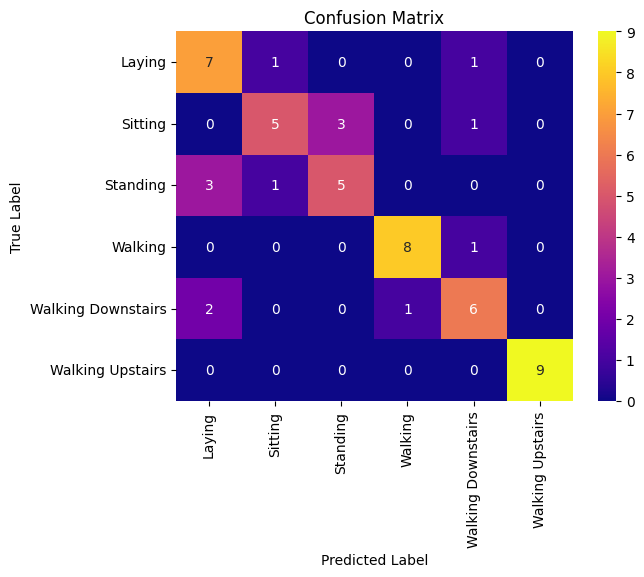

In [31]:
X_train_flattened = pd.DataFrame([df.values.flatten() for df in train_dataframes])
X_test_flattened = pd.DataFrame([df.values.flatten() for df in test_dataframes])

y_train = pd.Series(train_labels).reset_index(drop=True)
y_test = pd.Series(test_labels).reset_index(drop=True)

clf = DecisionTreeClassifier()
clf.fit(X_train_flattened, y_train)
y_pred = clf.predict(X_test_flattened)

accuracy = accuracy_score(y_test, y_pred) * 100

print(f"Accuracy of Decision Tree Classifier: {accuracy:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot=True, cmap='plasma', cbar=True, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. What are the limitations of Zero-Shot Learning and Few-Shot Learning in the context of classifying human activities based on featurized accelerometer data?

There are many limitations of using Large Language Models (LLMs) in general, especially for tasks such as classifying human activities based on featurized accelerometer data. The following are some common issues:

- **Pretrained knowledge**: These approaches rely heavily on pretrained knowledge to generate new tokens. While Few-Shot Learning is capable of "learning" from new context, it still does not perform well on niche, domain-specific tasks like human activity classification with featurized accelerometer data due to the lack of such examples in training. This is why models are first fine-tuned on custom datasets beforehand for tasks like this. This also helps eliminate the inherent bias associated with the task in the already existing model.

- **Scalability**: The scalability of using LLMs for classification tasks like this is bottlenecked by the context window of the LLM. In our case, Groq primarily has LLMs with a context window of size 8192. Mixtral had a slightly more generous limit of 32,768 tokens. Fortunately, Meta's new LLM - Llama 3.1 had the largest context window of 131,072 tokens. This turned out to be very useful in our case, especially for Few-Shot learning, as we could pass in more examples. However, using more tokens increases the time taken to process a prompt. 

- **Use Case**: LLMs are excellent in capturing semantic relationships between text. However, they might not perform as expected in tasks such as ours. One particularly famous and recent example is the question "Which number is greater: 9.9 or 9.11?" Llama 3 answered 9.11 which is incorrect. One probable reason for this is that numbers like 9.9 and 9.11 occur frequently in sites like GitHub and denote version numbers, and indeed, 9.11 is greater than 9.9 in such cases. Such results depend on the tokenizer used by the LLM. Llama 3's tokenizer treats "11" and "9" as single tokens, so it makes sense to say that 9.11 is greater than 9.9. This makes the approach of using LLMs ill-suited for our task as we work with data that is time-series, highly featurized, and very numerical.

Now for comparing the limitations of Zero-Shot Learning and Few-Shot Learning:

#### **Zero-Shot Learning**
1. It performs poorly when the activities are dissimilar from the pretrained training data of the model or when the features lack any meanigful semantic relationship, like in the case of featurized accelerometer data.
2. It often results in lower accuracy when compared to fully supervised methods. This can be demonstrated empirically as well by confirming that Few-Shot Learning and decision tree performed much better than it.

#### **Few-Shot Learning**
1. Few-Shot learning methods can often lead to overfitting. While experimenting, we found that it incorrectly predicted 100% of values correctly because we did not shuffle the data. We suspect that it was because we gave the data in order: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs repeatedly.
2. While passing many examples may aid the model in capturing more information, it uses many tokens. We were forced to use the model with the highest context window of 131,072 tokens to fit in all the examples. This is computationally expensive, both, in terms of cost and performance.

# 4. What does the model classify when given input from an entirely new activity that it hasn't seen before?

Let's remove 1 activity at a time and see what happens.

We demonstrated above that hiding one activity forces the model to output a different activity for that input. This is an empirical result specific to Llama 3.1. Models such as Mixtral may output phrases like "I am not sure but it looks like the activity is [activity]". Llama 3.1 appears to be obedient, and does not classify the activities to something outside of what was prompted. Also, some activities like Laying and Sitting are never at the top. For some reason, the models fail to classify these activities equally, which might indicate some inadvertent bias being introduced due to hiding activities.

In [10]:
cur_api_key = 9

query_str = """You are given some values of the following features of a human, in order:
1. tBodyAcc-mean()-X: Mean of the body acceleration signal in the X-axis (horizontal movement).
2. tBodyAcc-mean()-Y: Mean of the body acceleration signal in the Y-axis (vertical movement).
3. tBodyAcc-mean()-Z: Mean of the body acceleration signal in the Z-axis (lateral movement).
4. tGravityAcc-mean()-X: Mean of the gravity acceleration signal in the X-axis.
5. tGravityAcc-mean()-Y: Mean of the gravity acceleration signal in the Y-axis.
6. tGravityAcc-mean()-Z: Mean of the gravity acceleration signal in the Z-axis.
7. tBodyGyro_mean()_X: Mean of the body gyro signal in the X-axis.
8. tBodyGyro_mean()_Y: Mean of the body gyro signal in the Y-axis.
9. tBodyGyro_mean()_Z: Mean of the body gyro signal in the Z-axis.

Now classify the below activities into one of these activities: {activities}. Make sure you limit your response for each activity to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess:

"""

test_template = """
=======================================================
Activity {activity_number}:

{activity}

"""

activity_list = ['Laying', 'Sitting', 'Standing', 'Walking', 'Walking Upstairs', 'Walking Downstairs']
for activity in activity_list:
    temp_activity_list = activity_list.copy()
    temp_activity_list.remove(activity)
    s = ', '.join(temp_activity_list)
    temp_query_str = query_str.format(activities=s)
    temp_test_examples = []
    for example in test_examples:
        if example.classification == activity:
            temp_test_examples.append(example)
    print(f'Current removed activity is: {activity}')

    for cur_example, example in enumerate(temp_test_examples):
        temp_query_str += test_template.format(activity_number=cur_example + 1, activity=example.text)

    response = None
    while not response:
        try:
            llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
            response = llm.invoke(temp_query_str).content.strip()
        except:
            cur_api_key = (cur_api_key % num_api_keys) + 1

    response = response.split('\n')
    response = [activity_[max(activity_.index(':') if ':' in activity_ else -1, activity_.index('.') if '.' in activity_ else -1)+2:] for activity_ in response]
    response = pd.Series(response).value_counts(normalize=True) * 100
    display(response)

Current removed activity is: Laying


Walking               44.444444
Sitting               22.222222
Walking Downstairs    22.222222
Standing              11.111111
Name: proportion, dtype: float64

Current removed activity is: Sitting


Standing              33.333333
Walking               22.222222
Laying                22.222222
Walking Downstairs    11.111111
Walking Upstairs      11.111111
Name: proportion, dtype: float64

Current removed activity is: Standing


Walking               44.444444
Sitting               33.333333
Walking Downstairs    11.111111
Laying                11.111111
Name: proportion, dtype: float64

Current removed activity is: Walking


Standing              44.444444
Walking Downstairs    22.222222
Walking Upstairs      22.222222
Sitting               11.111111
Name: proportion, dtype: float64

Current removed activity is: Walking Upstairs


Standing    33.333333
Sitting     33.333333
Laying      22.222222
Walking     11.111111
Name: proportion, dtype: float64

Current removed activity is: Walking Downstairs


Standing    55.555556
Walking     22.222222
Sitting     22.222222
Name: proportion, dtype: float64

In [8]:
query_str = """You are given some values of the following features of a human, in order:
1. tBodyAcc-mean()-X: Mean of the body acceleration signal in the X-axis (horizontal movement).
2. tBodyAcc-mean()-Y: Mean of the body acceleration signal in the Y-axis (vertical movement).
3. tBodyAcc-mean()-Z: Mean of the body acceleration signal in the Z-axis (lateral movement).
4. tGravityAcc-mean()-X: Mean of the gravity acceleration signal in the X-axis.
5. tGravityAcc-mean()-Y: Mean of the gravity acceleration signal in the Y-axis.
6. tGravityAcc-mean()-Z: Mean of the gravity acceleration signal in the Z-axis.
7. tBodyGyro_mean()_X: Mean of the body gyro signal in the X-axis.
8. tBodyGyro_mean()_Y: Mean of the body gyro signal in the Y-axis.
9. tBodyGyro_mean()_Z: Mean of the body gyro signal in the Z-axis.

Your task is to classify the activity into one of the following classes: {activities}

Here are some examples to help you get started:
"""

example_template = """
=======================================================
- Activity:
{activity}

- Classification: {classification}
"""

ending_str = """
Now classify the below activity. Make sure you limit your response to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess. Also, do not add any punctuations. Limit your response to the exact classification and nothing else:

"""

activity_list = ['Laying', 'Sitting', 'Standing', 'Walking', 'Walking Upstairs', 'Walking Downstairs']
for activity in activity_list:
    temp_activity_list = activity_list.copy()
    temp_activity_list.remove(activity)
    s = ', '.join(temp_activity_list)
    temp_query_str = query_str.format(activities=s)
    temp_test_examples = []
    cnts = {}

    for example in test_examples:
        if example.classification == activity:
            temp_test_examples.append(example)
        else:
            if example.classification in cnts and cnts.get(example.classification, 0) >= 2:
                pass
            else:
                cnts[example.classification] = cnts.get(example.classification, 0) + 1
                temp_example_template = example_template.format(activity=example.text, classification=example.classification)
                temp_query_str += temp_example_template

                
    print(f'Current removed activity is: {activity}')

    temp_query_str += ending_str

    cur_example = 0
    cur_api_key = 1
    response_dict = {}

    while cur_example < len(temp_test_examples):
        try:
            llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
            response = llm.invoke(temp_query_str + temp_test_examples[cur_example].text).content.strip()
            response_dict[response] = response_dict.get(response, 0) + 1

            cur_example += 1
        except:
            cur_api_key = (cur_api_key % num_api_keys) + 1 

    response_dict = pd.Series(response_dict)
    response_dict = (response_dict / response_dict.sum()) * 100
    display(response_dict)

Current removed activity is: Laying


Walking             77.777778
Walking Upstairs    22.222222
dtype: float64

Current removed activity is: Sitting


Walking Upstairs    33.333333
Walking             22.222222
Laying              44.444444
dtype: float64

Current removed activity is: Standing


Walking Upstairs      66.666667
Walking Downstairs    22.222222
Walking               11.111111
dtype: float64

Current removed activity is: Walking


Walking Upstairs      88.888889
Walking Downstairs    11.111111
dtype: float64

Current removed activity is: Walking Upstairs


Walking     77.777778
Sitting     11.111111
Standing    11.111111
dtype: float64

Current removed activity is: Walking Downstairs


Standing    77.777778
Walking     11.111111
Laying      11.111111
dtype: float64

# 5. Test the model with random data (ensuring the data has the same dimensions and range as the previous input) and report the results.

By running the model with random data, we expect that the model should perform randomly, but that is not the case.

By running the model with random data, it is clear that there is some bias towards the walking activity. With Zero-Shot learning, "Walking" was classified about 1/3 times and with Few-Shot learning, it was classified about 2/3 times. Also, 3 of the 6 activities were never predicted via Few-Shot learning whereas with actual, deterministic data, we obtained an accuracy of 65%. This is solid evidence for the fact that the quality of data plays a huge part in the correctness of our predictions.

In [12]:
random_data = []
np.random.seed = 101

for i in range(30):
    df = pd.DataFrame(np.random.uniform(low=-1, high=1, size=(10, 9)), columns=['tBodyAcc_mean()_X', 'tBodyAcc_mean()_Y', 'tBodyAcc_mean()_Z', 'tGravityAcc_mean()_X', 'tGravityAcc_mean()_Y', 'tGravityAcc_mean()_Z', 'tBodyGyro_mean()_X', 'tBodyGyro_mean()_Y', 'tBodyGyro_mean()_Z'])
    random_data.append(Example(df, None, True, 2))

In [78]:
# testing with zero-shot learning
cur_api_key = 8
model_name = "llama-3.1-70b-versatile"

query_str = """You are given some values of the following features of a human, in order:
1. tBodyAcc-mean()-X: Mean of the body acceleration signal in the X-axis (horizontal movement).
2. tBodyAcc-mean()-Y: Mean of the body acceleration signal in the Y-axis (vertical movement).
3. tBodyAcc-mean()-Z: Mean of the body acceleration signal in the Z-axis (lateral movement).
4. tGravityAcc-mean()-X: Mean of the gravity acceleration signal in the X-axis.
5. tGravityAcc-mean()-Y: Mean of the gravity acceleration signal in the Y-axis.
6. tGravityAcc-mean()-Z: Mean of the gravity acceleration signal in the Z-axis.
7. tBodyGyro_mean()_X: Mean of the body gyro signal in the X-axis.
8. tBodyGyro_mean()_Y: Mean of the body gyro signal in the Y-axis.
9. tBodyGyro_mean()_Z: Mean of the body gyro signal in the Z-axis.

Now classify the below activities into one of these activities: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs. Make sure you limit your response for each activity to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess:

"""

test_template = """
=======================================================
Activity {activity_number}:

{activity}

"""

for cur_example, example in enumerate(random_data):
    query_str += test_template.format(activity_number=cur_example+1, activity=example.text)

response = None
while not response:
    try:
        llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
        response = llm.invoke(query_str).content.strip()
    except:
        cur_api_key = (cur_api_key % num_api_keys) + 1

In [83]:
classifications = [classification[classification.index(':')+2:] for classification in response.split('\n')]
classifications = pd.Series(classifications)
classifications = classifications.value_counts(normalize=True) * 100
print(f'Percentage-wise Distribution of Activities')
display(classifications)

Percentage-wise Distribution of Activities


Walking               31.666667
Sitting               18.333333
Standing              18.333333
Walking Downstairs    11.666667
Walking Upstairs      11.666667
Laying                 8.333333
Name: proportion, dtype: float64

In [13]:
query_str = """You are given some values of the following features of a human, in order:
1. tBodyAcc-mean()-X: Mean of the body acceleration signal in the X-axis (horizontal movement).
2. tBodyAcc-mean()-Y: Mean of the body acceleration signal in the Y-axis (vertical movement).
3. tBodyAcc-mean()-Z: Mean of the body acceleration signal in the Z-axis (lateral movement).
4. tGravityAcc-mean()-X: Mean of the gravity acceleration signal in the X-axis.
5. tGravityAcc-mean()-Y: Mean of the gravity acceleration signal in the Y-axis.
6. tGravityAcc-mean()-Z: Mean of the gravity acceleration signal in the Z-axis.
7. tBodyGyro_mean()_X: Mean of the body gyro signal in the X-axis.
8. tBodyGyro_mean()_Y: Mean of the body gyro signal in the Y-axis.
9. tBodyGyro_mean()_Z: Mean of the body gyro signal in the Z-axis.

Your task is to classify the activity into one of the following classes: Laying, Sitting, Standing, Walking, Walking Downstairs, Walking Upstairs.

Here are some examples to help you get started:
"""

example_template = """
=======================================================
- Activity:
{activity}

- Classification: {classification}
"""

for example in train_examples[::2]:
    query_str += example_template.format(activity=example.text, classification=example.classification)

for example in train_examples[1::2]:
    query_str += example_template.format(activity=example.text, classification=example.classification)

ending_str = """
Now classify the below activity. Make sure you limit your response to ONLY your classification, without providing any reasoning or justification for it. If you're not sure, return your best guess. Also, do not add any punctuations. Limit your response to the exact classification and nothing else:

"""

query_str += ending_str

responses = []
cur_example = 0
cur_api_key = 9

while cur_example < len(random_data):
    try:
        llm = ChatGroq(model=groq_models[model_name], api_key=os.environ[f'API_KEY_{cur_api_key}'], temperature=0)
        response = llm.invoke(query_str + random_data[cur_example].text).content.strip()
        responses.append(response)

        cur_example += 1
    except:
        cur_api_key = (cur_api_key % num_api_keys) + 1 

In [16]:
responses = pd.Series(responses)
responses = responses.value_counts(normalize=True)
responses

Walking             0.666667
Walking Upstairs    0.233333
Sitting             0.066667
                    0.033333
Name: proportion, dtype: float64